## Librairies et chargement des données 

In [4]:
# Importation des librairies principales
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du dataset
df = pd.read_csv("aircraft_price.csv")

# Aperçu initial
df.head()

,model_name,engine_type,engine_power,max_speed,cruise_speed,stall_speed,fuel_tank,all_eng_roc,out_eng_roc,takeoff_distance,landing_distance,empty_weight,length,wing_span,range,price
0,100 Darter (S.L. Industries),Piston,145.0,104.0,91.0,46.0,36.0,450.0,900.0,1300.0,2050.0,1180.0,303.0,449.0,370.0,1300000.0
1,7 CCM Champ,Piston,85.0,89.0,83.0,44.0,15.0,600.0,720.0,800.0,1350.0,820.0,247.0,433.0,190.0,1230000.0
2,100 Darter (S.L. Industries),Piston,90.0,90.0,78.0,37.0,19.0,650.0,475.0,850.0,1300.0,810.0,257.0,420.0,210.0,1600000.0
3,7 AC Champ,Piston,85.0,88.0,78.0,37.0,19.0,620.0,500.0,850.0,1300.0,800.0,257.0,420.0,210.0,1300000.0
4,100 Darter (S.L. Industries),Piston,65.0,83.0,74.0,33.0,14.0,370.0,632.0,885.0,1220.0,740.0,257.0,420.0,175.0,1250000.0


## Gestion des valeurs manquantes

In [5]:
# Vérification des valeurs manquantes
missing = df.isnull().mean().sort_values(ascending=False) * 100
display(missing)

# Imputation médiane pour les variables numériques
num_cols = df.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='median')
df[num_cols] = imputer.fit_transform(df[num_cols])

# Vérification post-imputation
df.isnull().sum().sum()

price               1.934236
model_name          0.000000
engine_type         0.000000
engine_power        0.000000
max_speed           0.000000
cruise_speed        0.000000
stall_speed         0.000000
fuel_tank           0.000000
all_eng_roc         0.000000
out_eng_roc         0.000000
takeoff_distance    0.000000
landing_distance    0.000000
empty_weight        0.000000
length              0.000000
wing_span           0.000000
range               0.000000
dtype: float64

np.int64(0)

## Détection et traitement des valeurs aberrantes

In [6]:
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Application sur les colonnes numériques
df_clean = remove_outliers_iqr(df, num_cols)
print(f"Nombre de lignes avant nettoyage : {df.shape[0]}")
print(f"Nombre de lignes après nettoyage : {df_clean.shape[0]}")

Nombre de lignes avant nettoyage : 517
Nombre de lignes après nettoyage : 276


## Encodage des variables catégorielles

In [7]:
cat_features = ['engine_type']
num_features = [col for col in df_clean.columns if col not in ['model_name', 'engine_type', 'price']]
target = 'price'

# Séparation X / y
X = df_clean.drop(columns=[target])
y = df_clean[target]


## Normalisation / Standardisation

In [8]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('select', SelectKBest(score_func=f_regression, k='all'))
])

## Construction du préprocesseur complet

In [9]:
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

full_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('final_scaler', MinMaxScaler())
])

## Application du pipeline et vérification


In [15]:
X_prepared = full_pipeline.fit_transform(X, y)

print(f"Forme initiale : {X.shape}")
print(f"Forme après preprocessing : {X_prepared.shape}")

Forme initiale : (276, 15)
Forme après preprocessing : (276, 105)


/Users/abdoulayediallo/Library/Caches/pypoetry/virtualenvs/aircraft-price-prediction-feAdyCom-py3.12/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:380: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


## Visualisation des variables transformées

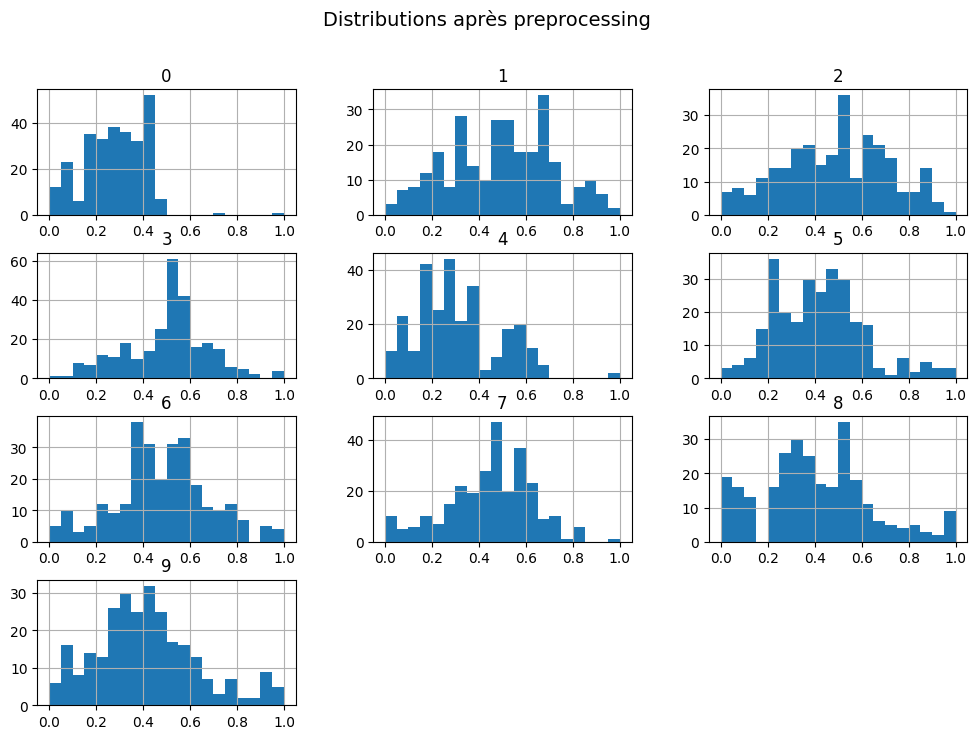

In [11]:
# Conversion en DataFrame pour visualisation
scaled_df = pd.DataFrame(X_prepared.toarray() if hasattr(X_prepared, "toarray") else X_prepared)
scaled_df.iloc[:, :10].hist(figsize=(12, 8), bins=20)
plt.suptitle("Distributions après preprocessing", fontsize=14)
plt.show()

## Sauvegarde du pipeline

In [14]:
import os

os.makedirs("../models", exist_ok=True)
joblib.dump(full_pipeline, "../models/preprocessing_pipeline.joblib")

print(" Pipeline sauvegardé dans : models/preprocessing_pipeline.joblib")

 Pipeline sauvegardé dans : models/preprocessing_pipeline.joblib
